In [1]:
import scenic
from scenic.simulators.carla.simulator import CarlaSimulator
from scenic.syntax.veneer import localPath
from scenic.core.regions import MeshVolumeRegion
from rulebook_benchmark.realization import Realization
import random

/home/ekin/anaconda3/envs/rulebook/lib/python3.8/site-packages/scenic/core/errors.py:271: UserWarning: unable to install sys.excepthook to format Scenic backtraces
  warnings.warn("unable to install sys.excepthook to format Scenic backtraces")


In [2]:
random.seed(3)

MAX_STEPS = 100

realization = Realization(MAX_STEPS)
scenario = scenic.scenarioFromFile('close_vru.scenic', params={"realization":realization}, mode2D=True)
scene, _ = scenario.generate()
simulator = CarlaSimulator(carla_map = 'Town01', map_path = localPath('../maps/Town01.xodr'))
simulation = simulator.simulate(scene, maxSteps=MAX_STEPS)

In [3]:
from rulebook_benchmark.rulebook import default_rulebook
total_violations, violation_histories = default_rulebook(realization)

print("Total violations: ", total_violations)
print("Violation histories: ", violation_histories)

Total violations:  [0, 0, 0, 0, 4.322495453267016, 7.340384476888917]
Violation histories:  [[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0], [

MovieWriter ffmpeg unavailable; using Pillow instead.


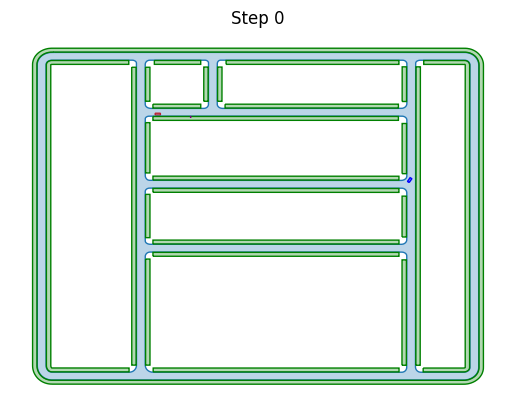

In [4]:
import shapely

import shapely.plotting
import matplotlib.pyplot as plt
import matplotlib.animation as animation

ego = realization.get_ego()
adv = realization.get_object(1)
network = realization.network

multiplier = 1

drivable_region = network.drivableRegion
walkable_region = network.walkableRegion
def update(frame):
    ax.clear()
    frame = frame*multiplier
    
    ego_state = ego.get_state(frame)
    
    
    ego_region = MeshVolumeRegion(mesh=ego.mesh, dimensions=ego.dimensions, rotation=ego_state.orientation, position=ego_state.position)
    
    
    shapely.plotting.plot_polygon(ego_region.boundingPolygon.polygons, ax=ax, add_points=False, color='red')    
    shapely.plotting.plot_polygon(drivable_region.polygons, ax=ax, add_points=False)
    shapely.plotting.plot_polygon(walkable_region.polygons, ax=ax, add_points=False, color='green')
    
    for adv in realization.objects_non_ego:
        
        adv_state = adv.get_state(frame)        
        adv_region = MeshVolumeRegion(mesh=adv.mesh, dimensions=adv.dimensions, rotation=adv_state.orientation, position=adv_state.position)
        if adv.object_type == 'Pedestrian':
            color = 'purple'
        else:
            color = 'blue'
        
        shapely.plotting.plot_polygon(adv_region.boundingPolygon.polygons, ax=ax, add_points=False, color=color)
    plt.title(f"Step {frame}")
    ax.set_xticks([])
    ax.set_yticks([])


    
    #delete frame around plot
    for spine in ax.spines.values():
        spine.set_visible(False)
    


    
fig, ax = plt.subplots()

anim = animation.FuncAnimation(fig, update, frames=MAX_STEPS//multiplier, repeat=False)
save_path = "scenario.gif"
anim.save(save_path, fps=20)



    

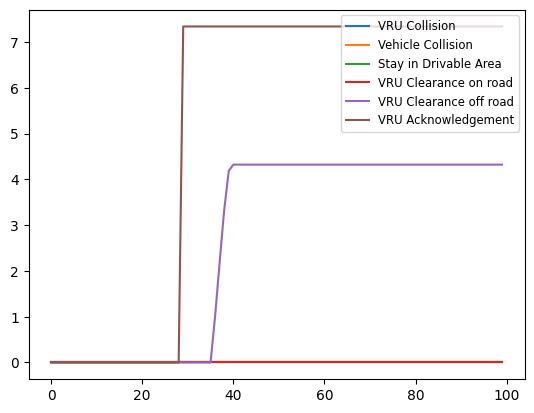

In [5]:

for history in violation_histories:
    plt.plot(history)
plt.legend(default_rulebook.rule_names, loc='upper right', fontsize='small')
#make legend smaller
plt.savefig("violation_histories.png")
plt.show()
